In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

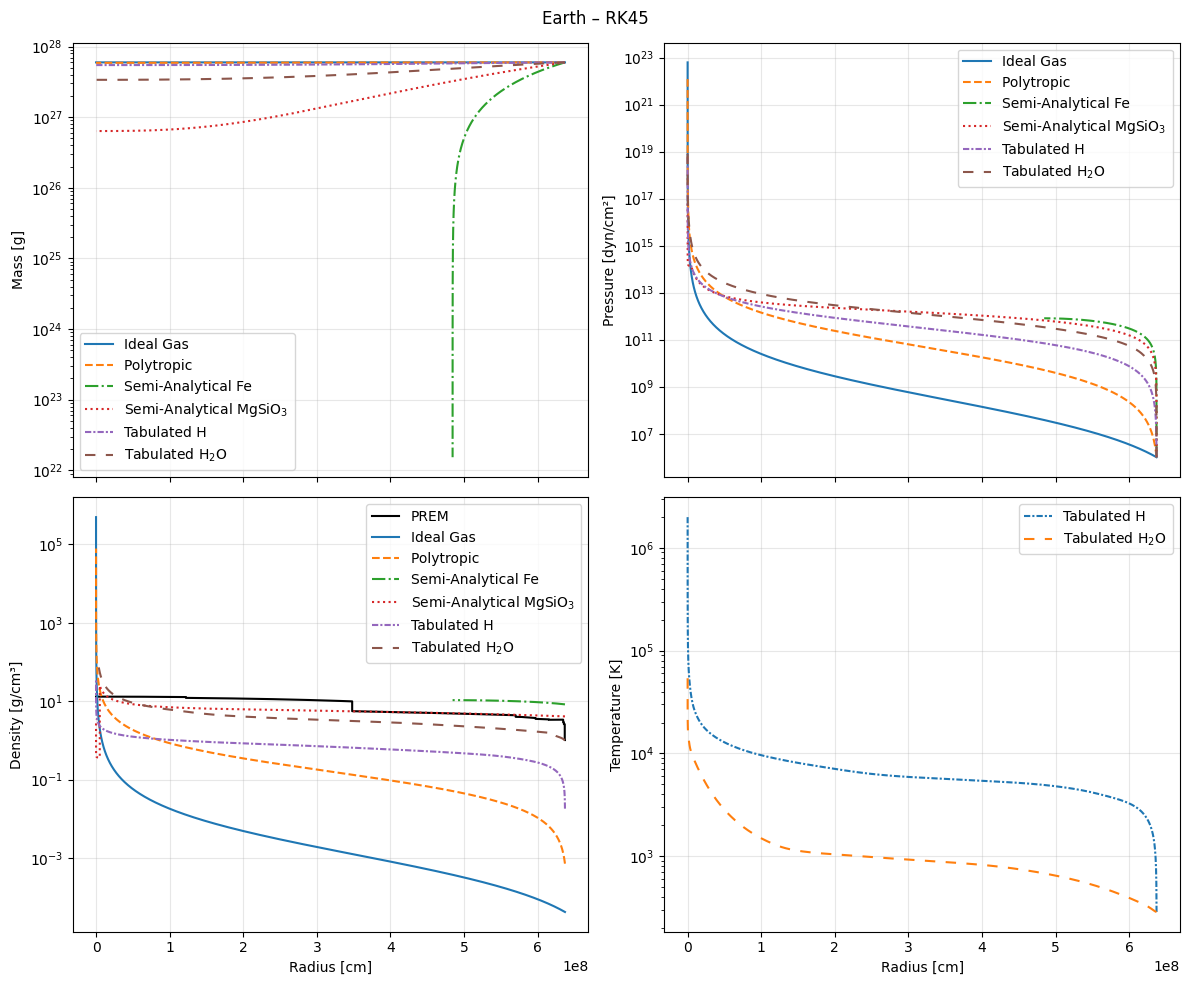

C:\Users\felix\AppData\Local\Temp\ipykernel_7076\2129150962.py:93: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, names=['r', 'rho'], delimiter=', ', skiprows=1)


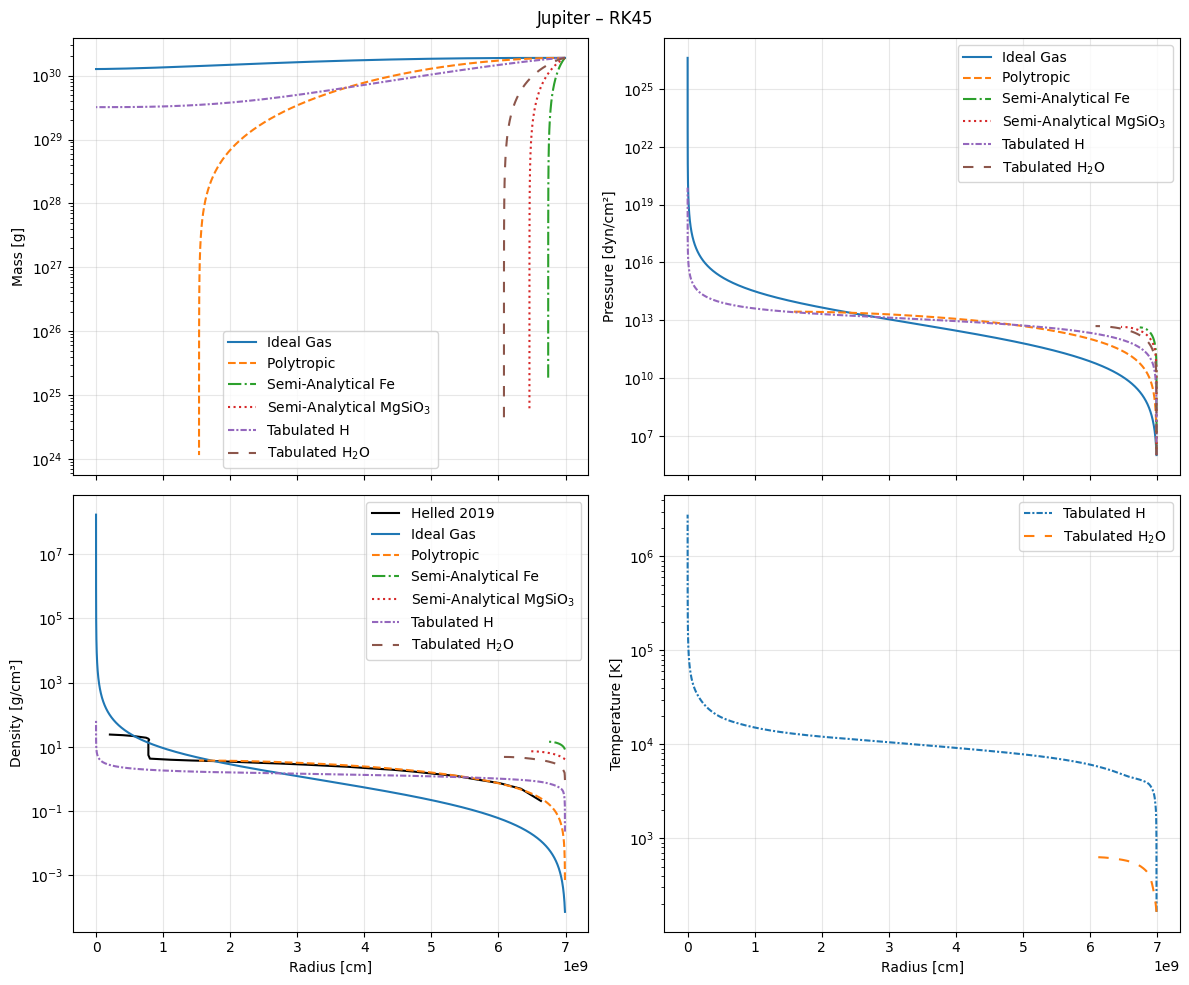

C:\Users\felix\AppData\Local\Temp\ipykernel_7076\2129150962.py:93: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, names=['r', 'rho'], delimiter=', ', skiprows=1)


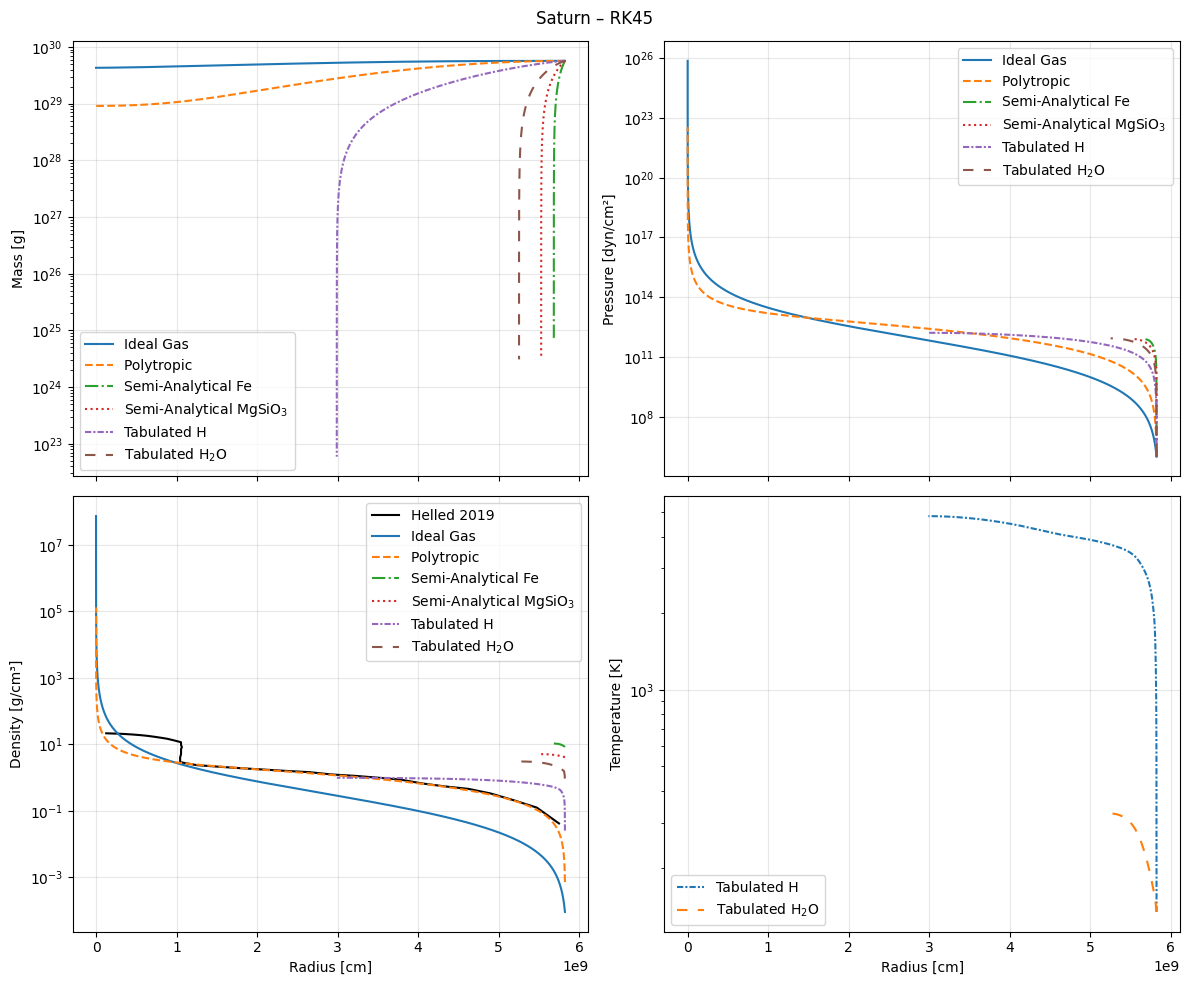

Target length for DataFrame columns: 512
Skipping 1D field with different length: layers_inconsistent (len=0)


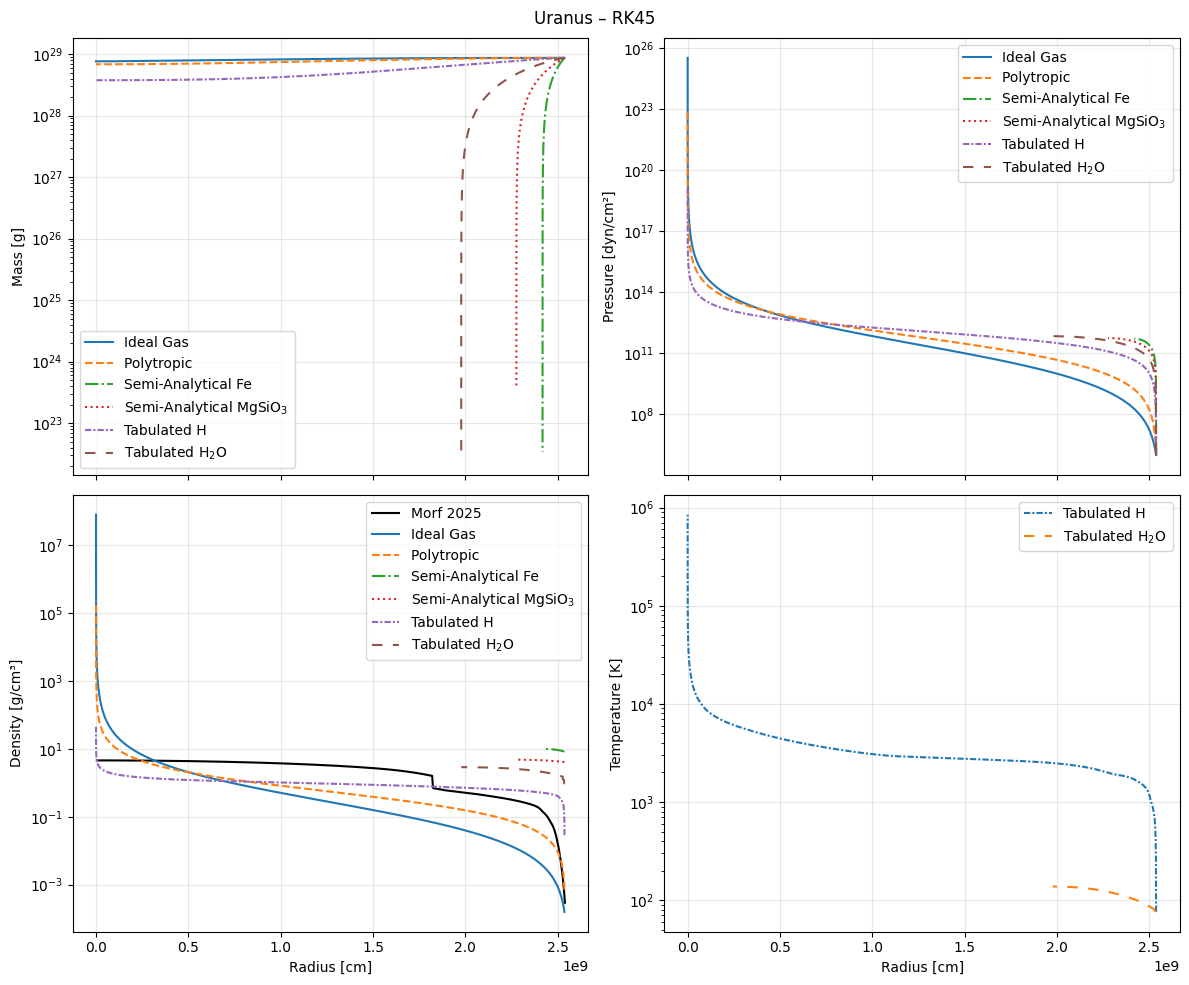

In [12]:
sim_names = {
    1 : '01_ideal_gas',
    2 : '02_polytropic',
    3 : '03_analytical_Fe',
    4 : '04_analytical_MgSiO3',
    5 : '05_tabulated_H',
    6 : '06_tabulated_H2O'
}

def nice_name(no):
    name = sim_names[no]
    name_parts = name.split('_')

    sim_name = ''
    for part in name_parts[1:]:
        if part == 'MgSiO3':
            part = 'MgSiO$_3$'
        elif part == 'H2O':
            part = 'H$_2$O'
        elif part == 'analytical':
            part = 'Semi-Analytical'
        if part and part[0].islower():
            part = part[0].upper() + part[1:]
        sim_name += part + ' '
    return sim_name

def plot_planet_x4(planet):
    # ------------------- load ------------------
    datas = []
    for no in [1,2,3,4,5,6]:
        file_name = f'{planet}_{sim_names[no]}_RK45_theta_2.csv'
        file_path = os.path.join('data', 'simulation_results', 'plot_4', planet, file_name)
        data = np.loadtxt(file_path, skiprows=1, delimiter=',') 
        datas.append(data)

    # ---------- load literature vaules ---------
    folder_path = os.path.join('data', 'Literature', planet)
    lit_densities = []
    
    if planet == 'Earth':
        file_path = os.path.join(folder_path, 'PREM500.csv')
        df = pd.read_csv(file_path, names=['radius','density','Vpv','Vsv','Q-kappa','Q-mu','Vph','Vsh','eta'])
        lit_radii = df['radius'].to_numpy() * 100 # m -> cm
        lit_densities = df['density'].to_numpy() * 1e-3 # kg/m^3 -> g/cm^3
        lit_name = 'PREM'

    elif planet == 'Uranus':
        def npz_to_dataframe_same_length(filename):
            data = np.load(filename, allow_pickle=True)

            # Collect lengths of 1D arrays
            lengths = {}
            for key in data.files:
                if key == "opts":
                    continue  # skip options object
                arr = np.array(data[key])
                if arr.ndim == 1:
                    lengths[key] = len(arr)

            if not lengths:
                raise ValueError("No 1D arrays found in file.")

            # Find the most common length among 1D arrays (likely the radial grid size)
            length_counts = Counter(lengths.values())
            target_len = length_counts.most_common(1)[0][0]

            print(f"Target length for DataFrame columns: {target_len}")

            columns = {}
            for key, L in lengths.items():
                arr = np.array(data[key])
                if L == target_len:
                    columns[key] = arr
                else:
                    print(f"Skipping 1D field with different length: {key} (len={L})")

            df = pd.DataFrame(columns)

            # Extract opts if present
            opts = data["opts"].item() if "opts" in data.files else None

            return df, opts
        
        file_path = os.path.join(folder_path, 'gen_4_comp_for_014_025_009_012_011_024_020_004.npz')
        df, _ = npz_to_dataframe_same_length(file_path)
        lit_radii = df['R'] # cm
        lit_densities = df['logRho'] # log10(g/cm^3)
        lit_densities = 10**lit_densities # log10(g/cm^3) -> g/cm^3
        lit_name = 'Morf 2025'

    elif planet == 'Jupiter' or planet == 'Saturn':
        file_path = os.path.join(folder_path, 'density.csv')
        df = pd.read_csv(file_path, names=['r', 'rho'], delimiter=', ', skiprows=1)
        lit_radii = df['r'].to_numpy() * 1e5 # km -> cm
        lit_densities = df['rho'].to_numpy() * 1e-3 # kg/m^3 -> g/cm^3
        lit_name = 'Helled 2019'

    # ------------------ plot -------------------
    # fig = plt.figure(figsize=(12, 10))
    # gs = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.25)
    
    # ax1 = fig.add_subplot(gs[0, 0])
    # ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)   # share x with ax1

    # ax2 = fig.add_subplot(gs[0, 1])
    # ax4 = fig.add_subplot(gs[1, 1], sharex=ax2)   # share x with ax2
    
    _, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
    ax1, ax2, ax3, ax4 = axs.ravel()
    
    # literature vaules
    ax3.plot(lit_radii, lit_densities, label=lit_name, color='black') # rho

    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]
    for linestyle, no, data in zip(linestyles, [1,2,3,4,5,6], datas):
        name = nice_name(no)
        # R0 = data[:,0][0]
        ax1.plot(data[:,0], data[:,1], label=name, linestyle=linestyle) # m
        ax2.plot(data[:,0], data[:,2], label=name, linestyle=linestyle) # P
        ax3.plot(data[:,0], data[:,3], label=name, linestyle=linestyle) # rho
        if data[:,5][-1] != 0:
            ax4.plot(data[:,0], data[:,5], label=name, linestyle=linestyle) # T

    # ---------- Formatting ----------
    legend_loc = {
        'Earth' : {
            1 : 'lower left',
            2 : 'upper right',
            3 : 'upper right',
            4 : 'upper right'
        },
        'Jupiter' : {
            1 : 'lower center',
            2 : 'upper right',
            3 : 'upper right',
            4 : 'upper right'
        },
        'Saturn' : {
            1 : 'lower left',
            2 : 'upper right',
            3 : 'upper right',
            4 : 'lower left'
        },
        'Uranus' : {
            1 : 'lower left',
            2 : 'upper right',
            3 : 'upper right',
            4 : 'upper right'
        }
    }
    
    ax1.set_yscale('log')
    ax1.set_ylabel("Mass [g]")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc=legend_loc[planet][1])
    
    ax2.set_yscale('log')
    ax2.set_ylabel("Pressure [dyn/cm²]")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc=legend_loc[planet][2])

    ax3.set_yscale('log')
    ax3.set_xlabel("Radius [cm]")
    ax3.set_ylabel("Density [g/cm³]")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc=legend_loc[planet][3])

    ax4.set_yscale('log')
    ax4.set_xlabel("Radius [cm]")
    ax4.set_ylabel("Temperature [K]")
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc=legend_loc[planet][4])

    plt.suptitle(f'{planet} \u2013 RK45')
    plt.tight_layout()

    # Save
    file_name = f'plot_4_different_EoS_{planet}_x4.pdf'
    folder_path = os.path.join('plots')
    file_path = os.path.join(folder_path, file_name)
    os.makedirs(folder_path, exist_ok=True)
    plt.savefig(file_path)

    plt.show()
    plt.close()

for planet in ['Earth', 'Jupiter', 'Saturn', 'Uranus']:
    plot_planet_x4(planet)